# Proposal of SCOPE Analysis: Apple Detection Validation Project

Notes: In this project exploratory analysis i use terms of *"projected"* as the indication for synthetization of data or rough assumptions, only for the project exploratory simulations purposes (contextual awareness and objective alignment), the actual facts and validity might actually far from accurate representative of SawitPro company

## S: Stakeholder Requirements & Success Criteria

### Primary Stakeholders:
- **Primary Stakeholders**: PT Digital Sawit Pro (SawitPro)
- **Data Labeling Team**: Requires accurately cropped and pre-classified apple images to be review
- **ML Team**: Elevate Refined data to fine-tune apple classification models

### Business Success Definition:
- Automated pre-classification system with at least 80% accuracy
- Enhancing Manual labelling efficiency
### Error Tolerance:
- **Type I errors (False Positives)**: Medium tolerance
  - *Business Impact*: Incorrect color classification requiring human resource
  - *Mitigation*: Human labeling team managed as a safety net
- **Type II errors (False Negatives)**: Medium tolerance
  - *Business Impact*: Missing apples in the image would reduce dataset size and potential
  - *Mitigation*: Good  object detection to ensure all apples are identified

### Interpretability Requirements:
- Clear visualization of cropped apple images with color classification labels
- Confidence scores for each classification to prioritize human review

```
Conclusion of Success Criteria:
1. Maximize apple detection precision and recall overall
2. Achieve reasonable color classification MAP
```

## C: Constraints & Context

### Computational Resources:
- **Training**: 
	- Low-performance GPU cluster at Engineer compute station (*projected*)
- **Inference**: 
	- Mid or Edge Device at plantation unit probably in remote locations with limited connectivity
	- Not requires of object tracking system as palm tree is a still object, which requires quality of coverage detection rather than fastest inference speed 
- **Field Use**: For Laptop or Mobile device that processing aerial images from drone (*projected*)

### Deployment Environment:
- Primary: Cloud-based processing pipeline
- Secondary: Laptop or Mobile Devices for offline processing
- Future consideration: 
	- Hybrid Cloud-based for main inference and local Model for backup inference mitigation

### Response Time Requirements:
- Job Processing or minimum delayed inference is still acceptable
- Inference Speed at least of 1 FPS on all target machines

### Data Constraints:
- Apple Characteristics:
  - Various Apple health quality that affect mixing color
  - Various sizes and shapes of apples
  - Different shades of red, yellow, and green
  - Partially visible apples due to occlusion
  - Mixed lighting conditions affecting color perception
- Image Characteristics:
  - Indoor and outdoor photography with varied lighting
  - Different camera qualities and resolutions
  - Potential shadows or reflections affecting color accuracy

## O: Objectives & Optimization Targets

### Primary Metric:
- AP across different class of apple
### Secondary Metrics:
- Recall (AR) across different tree densities (IOU overlapping: 0.5, 0.7, 0.9)
- MAP score for tree detection (balancing precision and recall) since the detection consist of multi class target
- Inference time per image

### Performance Thresholds:
- **Minimum Acceptable**: 
	- AP > 70%
	- R > 70%
- **Target**: MAP > 0.7
- **Stretch Goal**: MAP > 0.85 

### Acceptable Trade-offs:
- Precision vs. Recall: Prioritize Precision to ensure all apples are detected
- Speed vs. Accuracy: Reasonable processing time (1FPS) with high accuracy

```
Optimization Priority Order:
1. Precision (Detection Quality)
2. Recall (Detection Coverage)
3. Model size efficiency
4. Inference speed
```

## P: Problem Characteristics

### Problem Type:
- Two-stage machine learning task:
  1. Object detection to identify and crop individual apples
  2. Image classification to categorize apples by color (red, yellow, green)

### Data Characteristics:
- **Volume**: Variable number of apples per image (10 typical)
- **Dimensions**: Standard high-resolution photographs
- **Distribution**: 
  - Images may contain varying densities of apples, with some images featuring clusters and others having isolated apples.
  - Imbalanced representation of apple colors across the dataset.
  - Potential occlusion from leaves or other apples, complicating detection.
  
### Special Considerations:
- Including Rotten or Unhealthy apple
- Gradient Color of red, yellow, and green

## E: Evaluation Strategy

### Validation Approach:
### A. Dataset Splitting
- **Training Set**: 90% of the data for training
- **Validation Set**: 5% of the data for hyperparameters tuning.
- **Test Set**: 5% of the data for final evaluation
### B. Cross-Validation
- **K-Fold Cross-Validation**: If the dataset is large enough, use k-fold cross-validation

### Testing Methodology:
### A. A/B Testing
- **Implementation**: Compare the baseline model against alternative model
- **Metrics to Compare**: Use F1, AR, and AP to evaluate performance gap.
### B. Validation
- **Validation**: Conduct manual labeling of palm tree number to validate model predictions

### Monitoring Plan:

### A. Performance Monitoring
- **Real-Time Monitoring**: Set up dashboards to track model performance metrics during training and inference.

### B. Feedback Collection
- **User  Feedback**: Regularly gather input from the data labeling team regarding the usability of the interface and accuracy of classifications.
- **Iterative Improvements**: Use feedback and performance metrics to refine the model and retrain with updated datasets.

### Maintenance Strategy:
- **Retraining Schedule**: Schedule the regular model updates to incorporate new data and model improvement regarding to SawitPro computational power

## AI Model Development Approach Selection Framework

## Project Requirements:
1. **Time Constraints**: < 1 Week
2. **Team Expertise**: Software Engineers with some ML or General Developers
3. **Use Case Complexity**: Standard Object Detection (Not for research purpose)
4. **Data Availability**: Medium Dataset (500-1000 images)
5. **Deployment Environment**: :Local deployment, Edge Devices, Mobile Applications, Cloud Services

**Balance development speed vs. performance needs**:
   - MMDetection Model Toolbox
   - Model API Frameworks (Ultralytics)


Model Tuning Result:
1. Recall: 0.994
2. Precision: 0.899
3. MAP-50: 0.981
4. mAP50-95:  0.793
5. Model size efficiency
6. Inference speed: 2.5ms on Small 640x640 image 

In [ ]:
# Importing Necessary Packages
from ultralytics import YOLO
import ultralytics.data as data
import ultralytics.data.dataset as dataset
import ultralytics.data.build as build
from roboflow import Roboflow
from IPython.display import Image as IPyImage
from ultralytics.utils.benchmarks import benchmark
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Importing Dataset From Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("aerial-palm-tree").project("apple-tricolor")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to apple-tricolor-2 in yolov11:: 100%|██████████| 6672/6672 [00:01<00:00, 5771.03it/s]


In [2]:
dataset_path = '/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/data.yaml'

model = YOLO("yolo11n.pt")  # load a pretrained model (trained on general multi class COCO dataset)

In [3]:
# HYPERPARAMETER TUNING

# Training Model Hyperparameter tuning adjusted for uplifting the Recall (Coverage)
# imgsz: 640 # Keep using baseline image size as detection use sliding windows algorithm to sustain original image quality
# box: [0.02, 0.03, 0.04] # Lower values can help the model focus more on accurately predicting the bounding boxes, which can improve precision by reducing false positives.
# iou: 0.8 # Allows more overlapping bounding box to be persist, showing more faded or incomplete tree
# cls: [0.2, 0.3, 0.4] # help the model prioritize correctly classifying the detected objects, which is crucial for precision
# dfl: [1.0, 1.2, 1.5] # Adjust the quality of coordinate of bounding box 
# mixup: [0.0, 0.1, 0.2] # Allow more synhtesize augmenation for small dataset
# copy_paste: 0.3 # Mitigation for small datasets (by create new object arrangement that differ from neat layout of plantation)

# # Modified Inference parameter for higher recall (Coverage)
# conf: [0.3, 0.4, 0.5]  # Detection confidence threshold - higher for precision
# iou: [0.4, 0.45, 0.5]   # lower value for cleaner detections

search_space = {
    # Learning rate related
    'lr0': [0.01, 0.005, 0.001],  # initial learning rate
    'lrf': [0.01, 0.05, 0.1],     # final learning rate (as a fraction of lr0)
    
    # Optimizer related
    'momentum': [0.8, 0.9, 0.95],
    'weight_decay': [0.0005, 0.001, 0.005],

    # Augmentation
    'scale': [0.4, 0.5, 0.6],      # image scale (+/- gain)
    'mosaic': [0.5, 0.8, 1.0],     # mosaic probability
    'mixup': [0.0, 0.1, 0.2],      # mixup probability
    'copy_paste': [0.0, 0.1, 0.2],
    
    # Loss function weights
    'box': [0.02, 0.03, 0.04],      # box loss weight
    'cls': [0.2, 0.3, 0.4],        # class loss weight
    'dfl': [1.0, 1.2, 1.5],        # Distribution Focal Loss weight
    
    # Warmup settings
    'warmup_epochs': [1, 3, 5],
    'warmup_momentum': [0.5, 0.8, 0.95],
}

In [4]:
tuned_model = YOLO("yolo11n.pt")
tuned_model.tune(data=dataset_path, space=search_space, epochs=10, iterations=4, optimizer="AdamW", plots=True, device=0, save=True, val=False)

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune16'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/4 with hyperparameters: {'lr0': 0.005, 'lrf': 0.01, 'momentum': 0.9, 'weight_decay': 0.0005, 'scale': 0.5, 'mosaic': 0.8, 'mixup': 0.0, 'copy_paste': 0.0, 'box': 0.03, 'cls': 0.3, 'dfl': 1.2, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8}
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, a

E0000 00:00:1742219623.174539    1394 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742219623.180415    1394 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742219623.195084    1394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742219623.195104    1394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742219623.195106    1394 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742219623.195108    1394 computation_placer.cc:177] computation placer already registered. Please check linka

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/train/labels.cache... 3063 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3063/3063 [00:00<?, ?it/s]
val: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/valid/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]


Plotting labels to runs/detect/train18/labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train18
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.2G   0.004531     0.5526      1.038         11        640: 100%|██████████| 192/192 [00:25<00:00,  7.51it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.21G    0.00457      0.412      1.048         21        640: 100%|██████████| 192/192 [00:20<00:00,  9.21it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.23G   0.004413     0.3651      1.038         12        640: 100%|██████████| 192/192 [00:20<00:00,  9.50it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.24G   0.004291     0.3262      1.023         16        640: 100%|██████████| 192/192 [00:21<00:00,  9.10it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.26G   0.004132     0.3068      1.006         11        640: 100%|██████████| 192/192 [00:21<00:00,  8.98it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.27G   0.004056     0.2871     0.9869         16        640: 100%|██████████| 192/192 [00:21<00:00,  8.85it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.27G   0.004002     0.2721     0.9711         17        640: 100%|██████████| 192/192 [00:21<00:00,  8.85it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.27G   0.003924     0.2612     0.9653         15        640: 100%|██████████| 192/192 [00:21<00:00,  9.08it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.27G   0.003818     0.2489     0.9529         11        640: 100%|██████████| 192/192 [00:21<00:00,  9.04it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.27G   0.003802     0.2347      0.951         14        640: 100%|██████████| 192/192 [00:21<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


                   all        180        536      0.983      0.996      0.993       0.75

10 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train18/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train18/weights/best.pt, 5.5MB

Validating runs/detect/train18/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


                   all        180        536      0.983      0.996      0.993       0.75
                 Green        174        530      0.976      0.991       0.99       0.73
                   Red          6          6      0.991          1      0.995       0.77
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/train18
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved runs/detect/tune16/tune_scatter_plots.png
Saved runs/detect/tune16/tune_fitness.png

Tuner: 1/4 iterations complete ✅ (253.77s)
Tuner: Results saved to runs/detect/tune16
Tuner: Best fitness=0.77447 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.98329, 'metrics/recall(B)': 0.9957, 'metrics/mAP50(B)': 0.9926, 'metrics/mAP50-95(B)': 0.75024, 'val/box_loss': 0.00399, 'val/cls_loss': 0.24638, 'val/dfl_loss': 0.9434, 'fitness': 0.77447}
Tuner: Best fitness model is runs/detect/train18
Tuner: Best fitness hyperparam

E0000 00:00:1742219876.908367    1628 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742219876.914169    1628 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742219876.928538    1628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742219876.928557    1628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742219876.928559    1628 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742219876.928561    1628 computation_placer.cc:177] computation placer already registered. Please check linka

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/train/labels.cache... 3063 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3063/3063 [00:00<?, ?it/s]
val: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/valid/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]


Plotting labels to runs/detect/train19/labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train19
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.2G    0.00452     0.5448      1.022         11        640: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.21G   0.004546     0.3943       1.03         21        640: 100%|██████████| 192/192 [00:22<00:00,  8.67it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.23G   0.004424      0.352      1.025         12        640: 100%|██████████| 192/192 [00:21<00:00,  8.80it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.24G   0.004294     0.3281      1.006         16        640: 100%|██████████| 192/192 [00:21<00:00,  8.91it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.26G   0.004193      0.305      0.995         11        640: 100%|██████████| 192/192 [00:21<00:00,  8.96it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.27G   0.004054     0.2819     0.9821         16        640: 100%|██████████| 192/192 [00:21<00:00,  8.79it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.27G   0.004031     0.2709     0.9848         17        640: 100%|██████████| 192/192 [00:21<00:00,  8.99it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.27G    0.00393     0.2588     0.9638         15        640: 100%|██████████| 192/192 [00:21<00:00,  8.89it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.27G    0.00383     0.2466     0.9532         11        640: 100%|██████████| 192/192 [00:21<00:00,  8.96it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.27G   0.003809     0.2326     0.9457         14        640: 100%|██████████| 192/192 [00:21<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


                   all        180        536      0.983      0.997      0.992      0.738

10 epochs completed in 0.065 hours.
Optimizer stripped from runs/detect/train19/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train19/weights/best.pt, 5.5MB

Validating runs/detect/train19/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.24it/s]


                   all        180        536      0.983      0.997      0.992      0.738
                 Green        174        530      0.976      0.994      0.989      0.726
                   Red          6          6      0.991          1      0.995       0.75
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/train19
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved runs/detect/tune16/tune_scatter_plots.png
Saved runs/detect/tune16/tune_fitness.png

Tuner: 2/4 iterations complete ✅ (511.36s)
Tuner: Results saved to runs/detect/tune16
Tuner: Best fitness=0.77447 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.98329, 'metrics/recall(B)': 0.9957, 'metrics/mAP50(B)': 0.9926, 'metrics/mAP50-95(B)': 0.75024, 'val/box_loss': 0.00399, 'val/cls_loss': 0.24638, 'val/dfl_loss': 0.9434, 'fitness': 0.77447}
Tuner: Best fitness model is runs/detect/train18
Tuner: Best fitness hyperparam

E0000 00:00:1742220134.782763    1831 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742220134.788594    1831 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742220134.803097    1831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742220134.803111    1831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742220134.803113    1831 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742220134.803115    1831 computation_placer.cc:177] computation placer already registered. Please check linka

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/train/labels.cache... 3063 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3063/3063 [00:00<?, ?it/s]
val: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/valid/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]


Plotting labels to runs/detect/train20/labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train20
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.23G   0.004649     0.5524     0.8718         11        640: 100%|██████████| 192/192 [00:24<00:00,  7.84it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.24G   0.004614     0.3957     0.8725         21        640: 100%|██████████| 192/192 [00:21<00:00,  9.08it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.26G   0.004442     0.3579     0.8582         12        640: 100%|██████████| 192/192 [00:20<00:00,  9.16it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.27G   0.004321      0.325     0.8418         16        640: 100%|██████████| 192/192 [00:20<00:00,  9.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.29G   0.004145     0.3058     0.8296         11        640: 100%|██████████| 192/192 [00:20<00:00,  9.19it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.3G   0.004084     0.2852     0.8242         16        640: 100%|██████████| 192/192 [00:21<00:00,  9.01it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       2.3G   0.004027     0.2691      0.813         17        640: 100%|██████████| 192/192 [00:21<00:00,  8.94it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.3G   0.003942     0.2627     0.8017         15        640: 100%|██████████| 192/192 [00:21<00:00,  9.13it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       2.3G   0.003846     0.2468     0.7957         11        640: 100%|██████████| 192/192 [00:21<00:00,  9.09it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       2.3G    0.00382     0.2365     0.7909         14        640: 100%|██████████| 192/192 [00:21<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


                   all        180        536      0.976       0.99      0.992      0.756

10 epochs completed in 0.063 hours.
Optimizer stripped from runs/detect/train20/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train20/weights/best.pt, 5.5MB

Validating runs/detect/train20/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


                   all        180        536      0.976       0.99      0.992      0.756
                 Green        174        530      0.983       0.98       0.99      0.731
                   Red          6          6      0.969          1      0.995      0.781
Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train20
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved runs/detect/tune16/tune_scatter_plots.png
Saved runs/detect/tune16/tune_fitness.png

Tuner: 3/4 iterations complete ✅ (763.25s)
Tuner: Results saved to runs/detect/tune16
Tuner: Best fitness=0.77975 observed at iteration 3
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.97594, 'metrics/recall(B)': 0.99003, 'metrics/mAP50(B)': 0.99227, 'metrics/mAP50-95(B)': 0.75613, 'val/box_loss': 0.00404, 'val/cls_loss': 0.25129, 'val/dfl_loss': 0.77331, 'fitness': 0.77975}
Tuner: Best fitness model is runs/detect/train20
Tuner: Best fitness hyperpa

E0000 00:00:1742220386.428953    2010 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742220386.434794    2010 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742220386.449511    2010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742220386.449529    2010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742220386.449531    2010 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742220386.449549    2010 computation_placer.cc:177] computation placer already registered. Please check linka

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/train/labels.cache... 3063 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3063/3063 [00:00<?, ?it/s]
val: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/valid/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]


Plotting labels to runs/detect/train21/labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.86113) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train21
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.23G   0.004716      0.564      0.896         11        640: 100%|██████████| 192/192 [00:25<00:00,  7.67it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.24G   0.004627     0.3964     0.8879         21        640: 100%|██████████| 192/192 [00:21<00:00,  8.91it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.26G   0.004448      0.351     0.8723         12        640: 100%|██████████| 192/192 [00:21<00:00,  8.99it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.27G   0.004292     0.3192     0.8508         16        640: 100%|██████████| 192/192 [00:21<00:00,  9.02it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.29G   0.004172     0.2989     0.8479         11        640: 100%|██████████| 192/192 [00:21<00:00,  9.09it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       2.3G   0.004098     0.2811     0.8361         16        640: 100%|██████████| 192/192 [00:21<00:00,  8.98it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.31G   0.004025     0.2692     0.8259         17        640: 100%|██████████| 192/192 [00:21<00:00,  8.79it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.31G   0.003955      0.259     0.8135         15        640: 100%|██████████| 192/192 [00:21<00:00,  9.05it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.31G   0.003857     0.2456     0.8053         11        640: 100%|██████████| 192/192 [00:21<00:00,  9.06it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.31G   0.003825     0.2348     0.8012         14        640: 100%|██████████| 192/192 [00:21<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


                   all        180        536      0.984      0.991      0.994      0.763

10 epochs completed in 0.064 hours.
Optimizer stripped from runs/detect/train21/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train21/weights/best.pt, 5.5MB

Validating runs/detect/train21/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


                   all        180        536      0.984      0.991      0.994      0.762
                 Green        174        530      0.983      0.982      0.992      0.732
                   Red          6          6      0.985          1      0.995      0.792
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train21
💡 Learn more at https://docs.ultralytics.com/modes/train
Saved runs/detect/tune16/tune_scatter_plots.png
Saved runs/detect/tune16/tune_fitness.png

Tuner: 4/4 iterations complete ✅ (1017.25s)
Tuner: Results saved to runs/detect/tune16
Tuner: Best fitness=0.78584 observed at iteration 4
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.98387, 'metrics/recall(B)': 0.99114, 'metrics/mAP50(B)': 0.99355, 'metrics/mAP50-95(B)': 0.76276, 'val/box_loss': 0.00403, 'val/cls_loss': 0.24245, 'val/dfl_loss': 0.7848, 'fitness': 0.78584}
Tuner: Best fitness model is runs/detect/train21
Tuner: Best fitness hyperpa

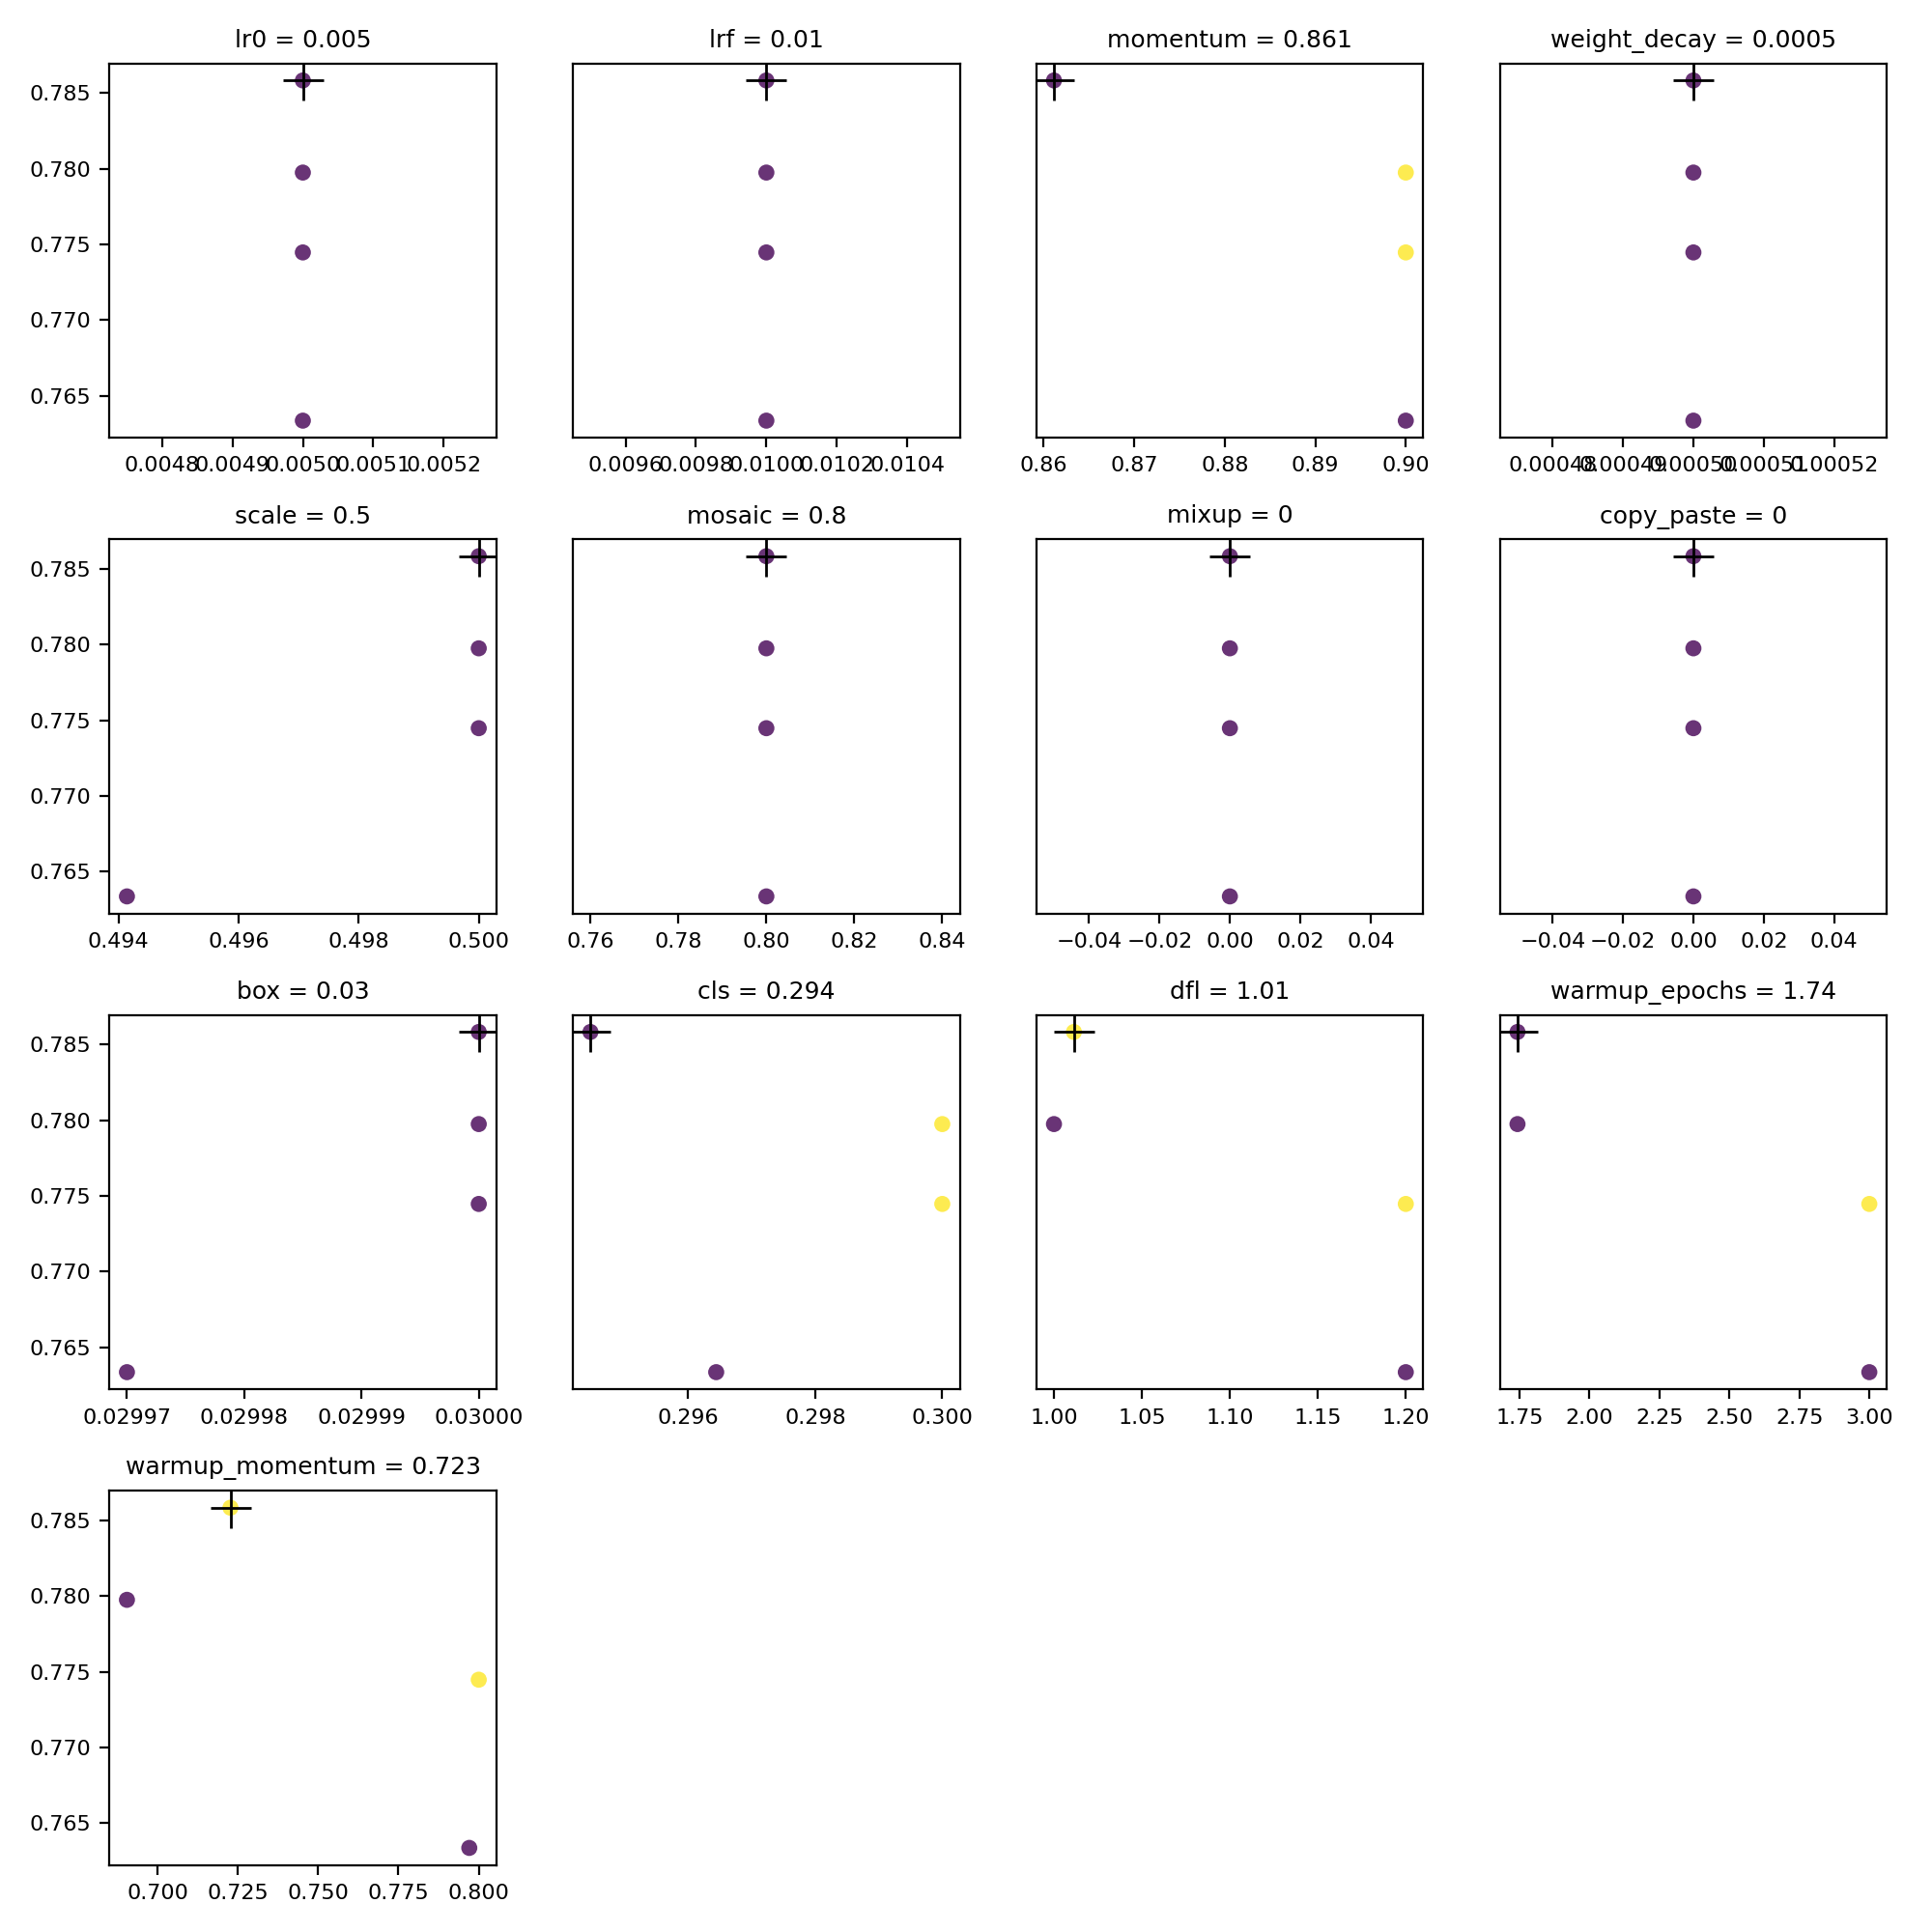

In [5]:
# Result of Detection
IPyImage(filename='/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/tune16/tune_scatter_plots.png', width=600)

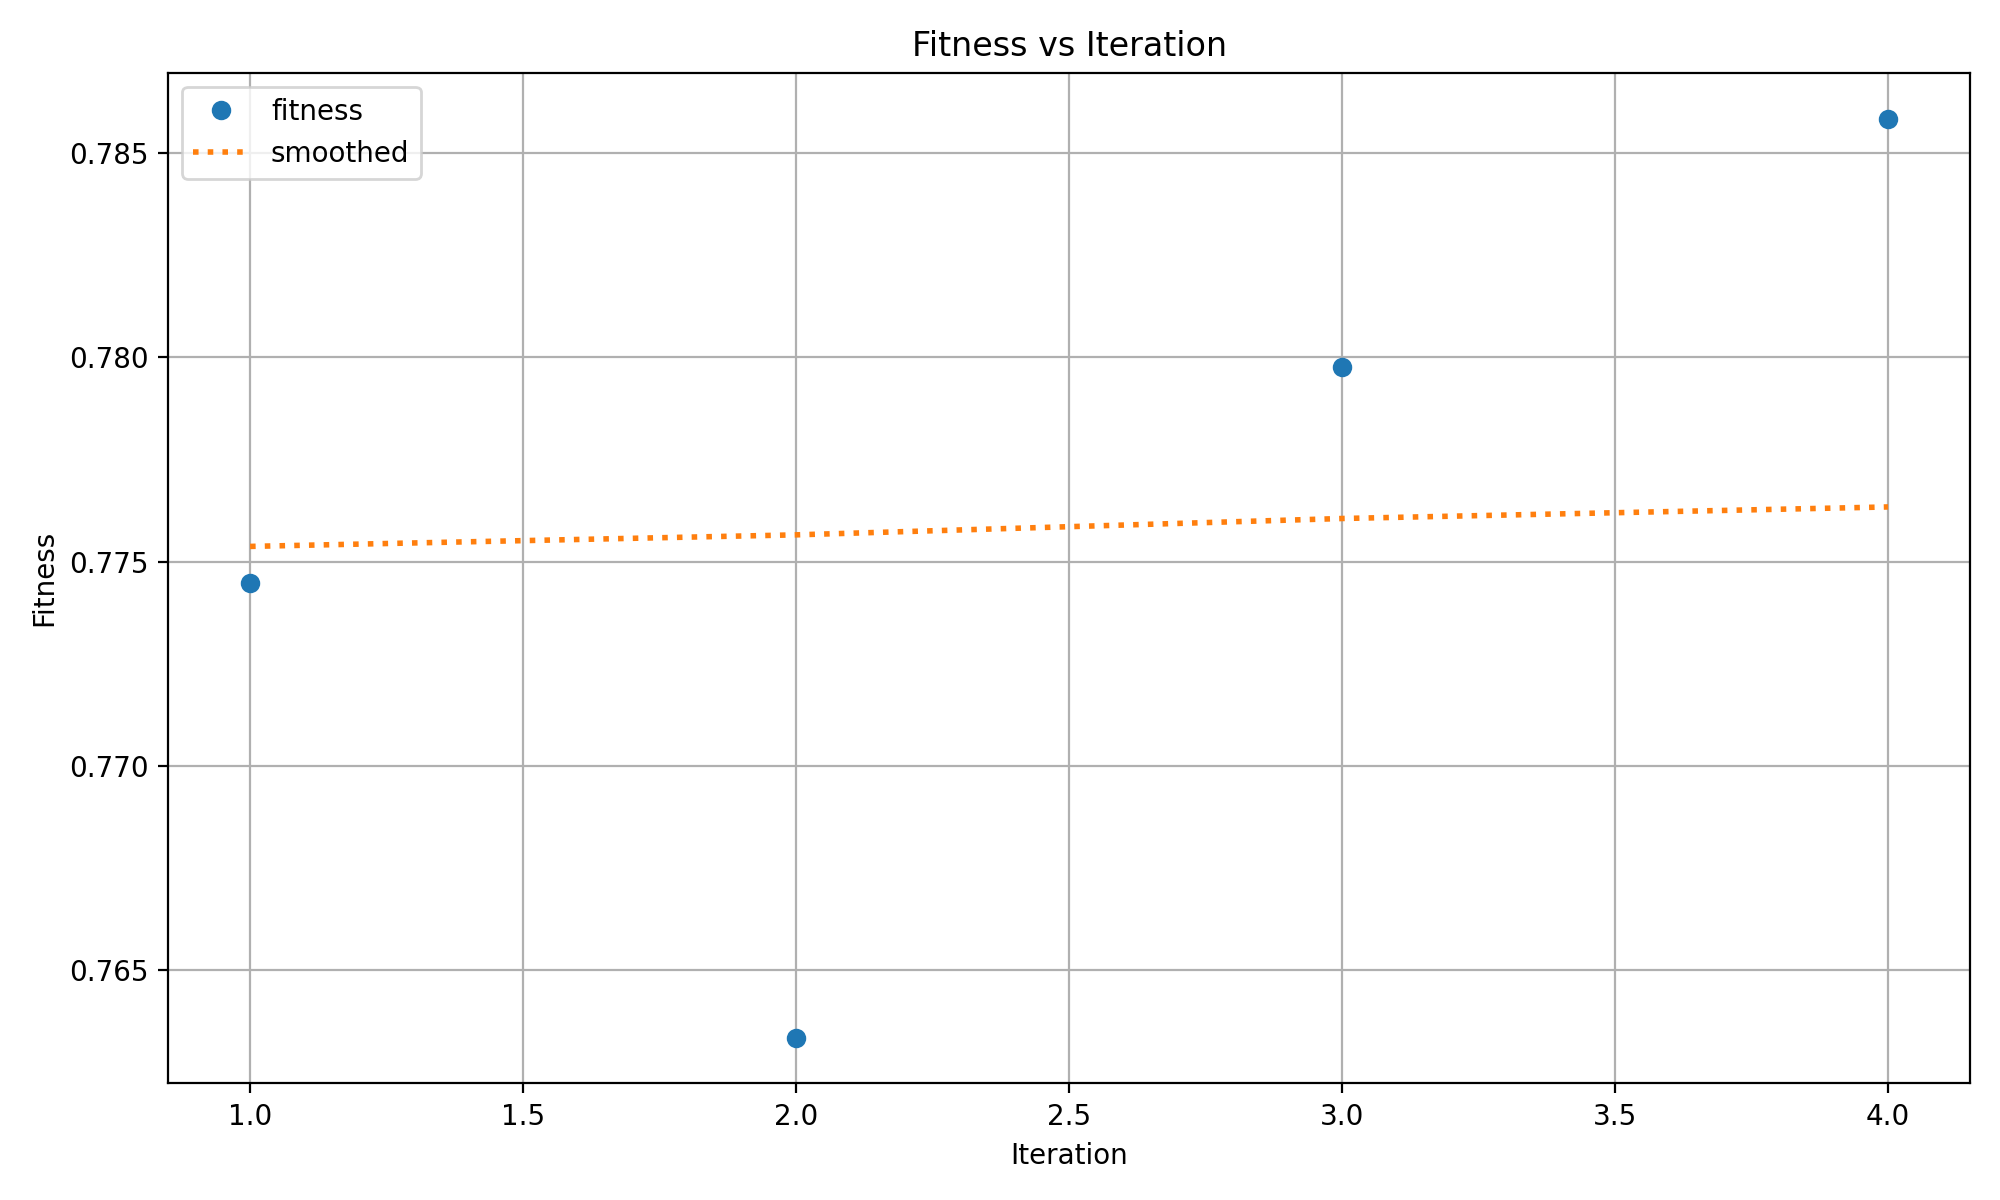

In [6]:
# Result of Detection
IPyImage(filename='/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/tune16/tune_fitness.png', width=600)

In [28]:
# Class for generating balance weight for heavy imbalance Apple Dataset

class YOLOWeightedDataset(data.dataset.YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts

        # Aggregation function
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()
    
    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

In [27]:
# RE-TRAINING WITH ADJUSTED HYPERPARAMETER

dataset.YOLODataset = YOLOWeightedDataset # initialization for dataset weight balancer

custom_model = YOLO("yolo11n.pt")
config_file = "/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/tune16/best_hyperparameters.yaml"

custom_model_results = custom_model.train(cfg=config_file, data=dataset_path, epochs=10, imgsz=640, device=0, plots=True, save=True)

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_tx

train: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/train/labels.cache... 3063 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3063/3063 [00:00<?, ?it/s]
val: Scanning /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/apple-tricolor-2/valid/labels.cache... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]


Plotting labels to runs/detect/train23/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.86113' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train23
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.25G   0.004213      0.819     0.8255         11        640: 100%|██████████| 192/192 [00:25<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]

                   all        180        536      0.863      0.595      0.882      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.39G   0.004252     0.5022     0.8263         21        640: 100%|██████████| 192/192 [00:24<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        180        536      0.952      0.784      0.874      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.41G    0.00416     0.3778     0.8164         12        640: 100%|██████████| 192/192 [00:23<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.44it/s]

                   all        180        536      0.987      0.907      0.912      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.42G   0.004087     0.3135     0.8053         16        640: 100%|██████████| 192/192 [00:22<00:00,  8.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.54it/s]

                   all        180        536      0.979      0.995      0.991       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.42G   0.004014     0.2917      0.802         11        640: 100%|██████████| 192/192 [00:24<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]

                   all        180        536      0.981      0.913       0.97       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.42G   0.003912     0.2657     0.7909         16        640: 100%|██████████| 192/192 [00:23<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]

                   all        180        536      0.982      0.999      0.991      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.42G    0.00386     0.2517      0.783         17        640: 100%|██████████| 192/192 [00:24<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]

                   all        180        536      0.975      0.992      0.991      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.42G   0.003784      0.241     0.7765         15        640: 100%|██████████| 192/192 [00:23<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]

                   all        180        536      0.899      0.994      0.981      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.43G   0.003715     0.2308     0.7723         11        640: 100%|██████████| 192/192 [00:23<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.57it/s]

                   all        180        536      0.976      0.989       0.99      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.45G     0.0037     0.2195     0.7718         14        640: 100%|██████████| 192/192 [00:23<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.58it/s]

                   all        180        536      0.984      0.992      0.991      0.766



10 epochs completed in 0.071 hours.
Optimizer stripped from runs/detect/train23/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train23/weights/best.pt, 5.5MB

Validating runs/detect/train23/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 11902MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


                   all        180        536      0.899      0.994      0.981      0.793
                 Green        174        530      0.985      0.987      0.989      0.725
                   Red          6          6      0.813          1      0.972      0.862
Speed: 0.1ms preprocess, 2.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train23


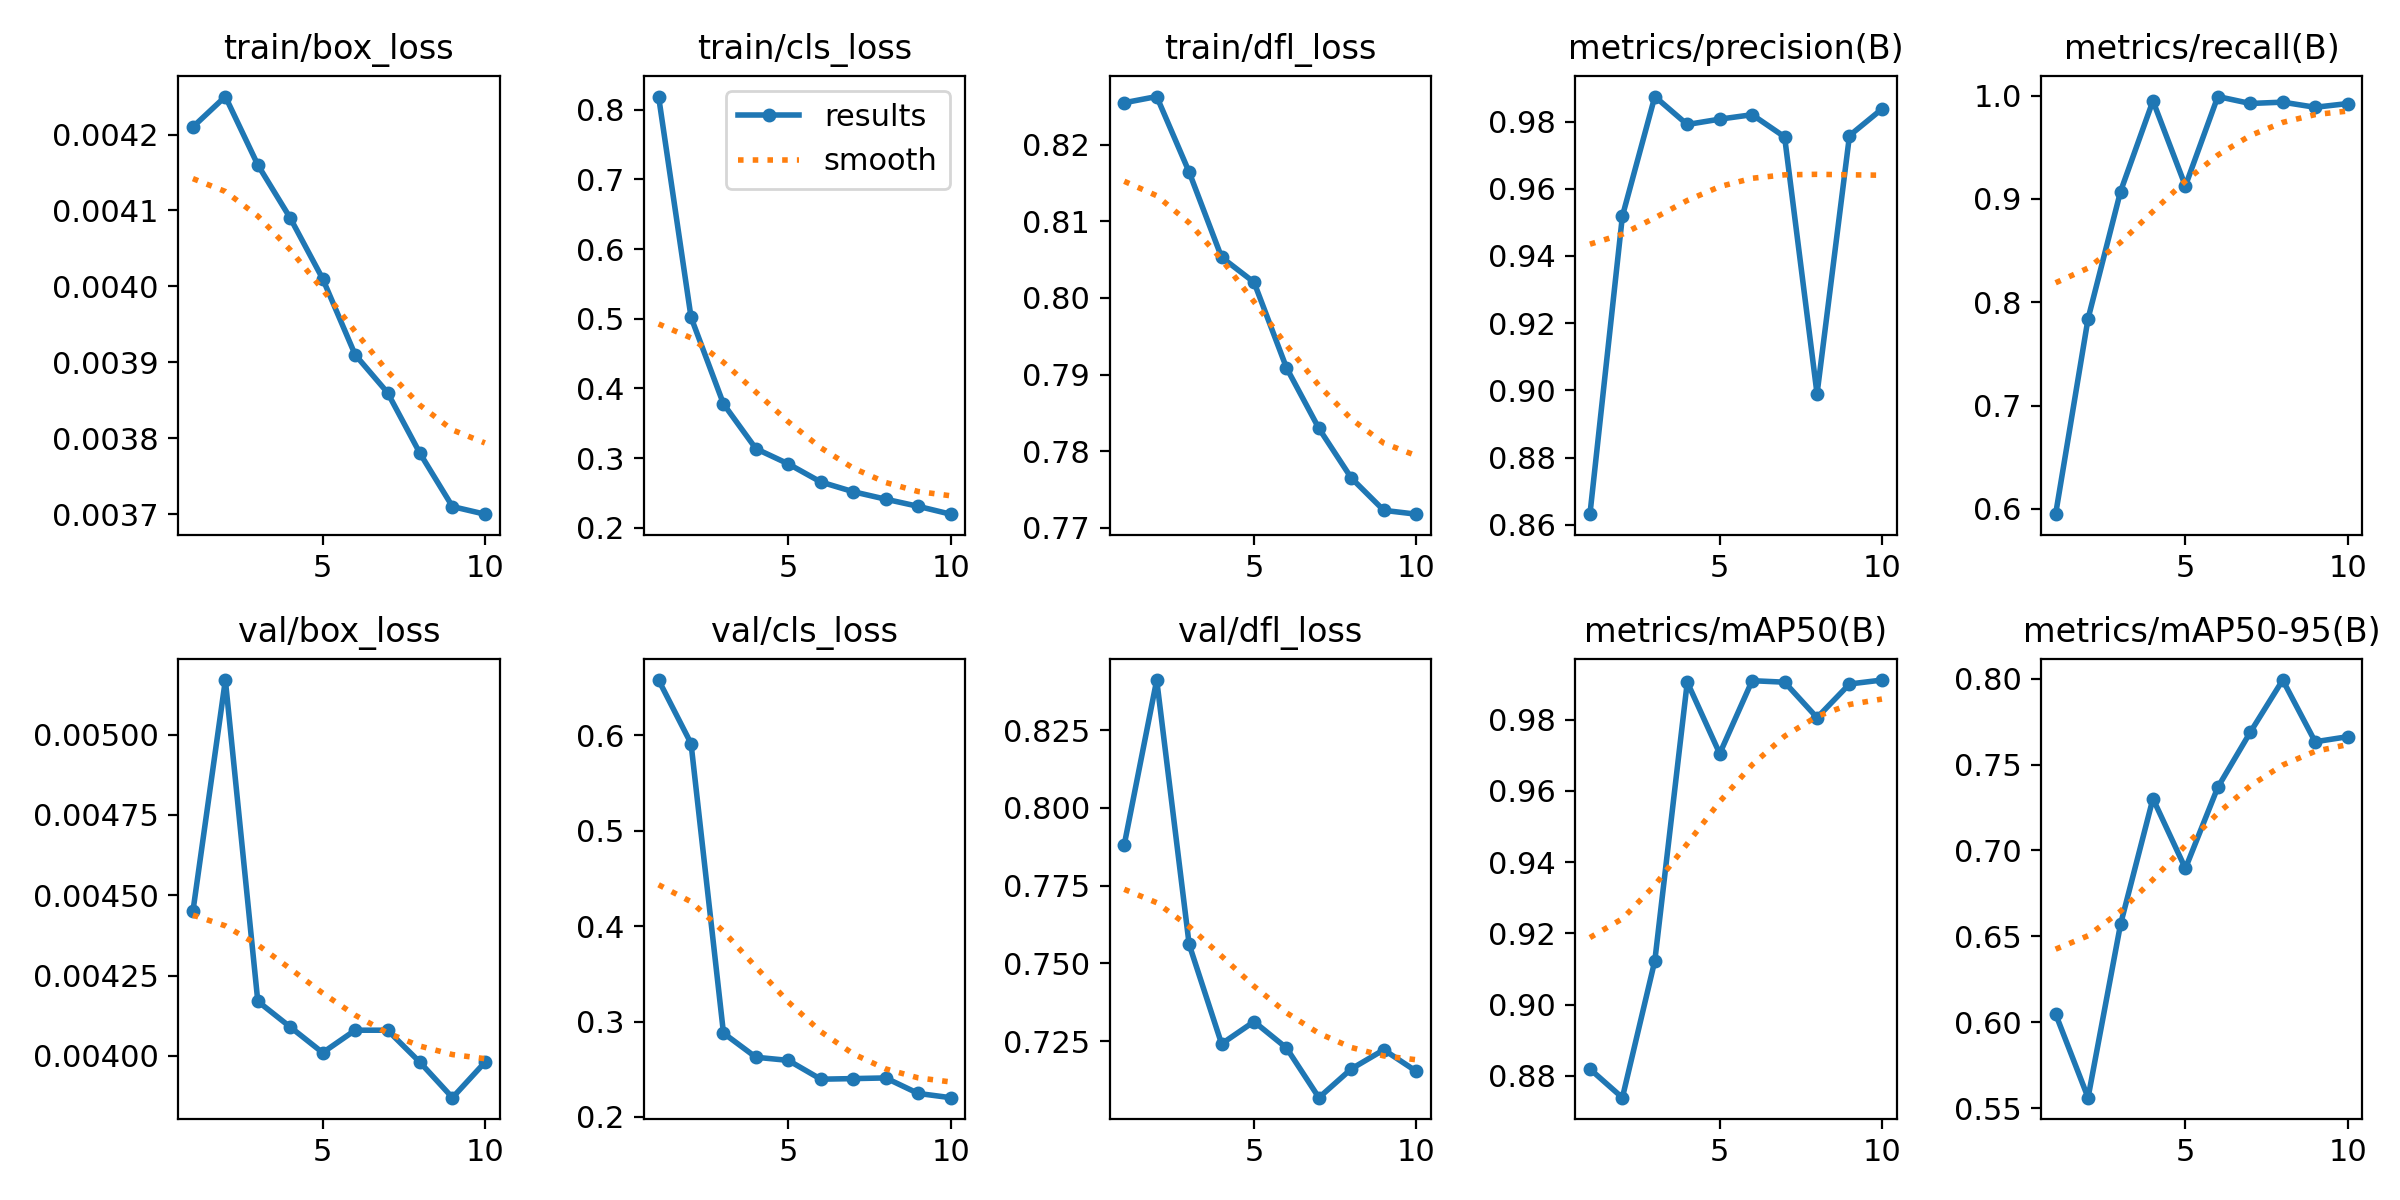

In [29]:
# Overall Training Metrics Result 
IPyImage(filename='/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/train23/results.png', width=600)

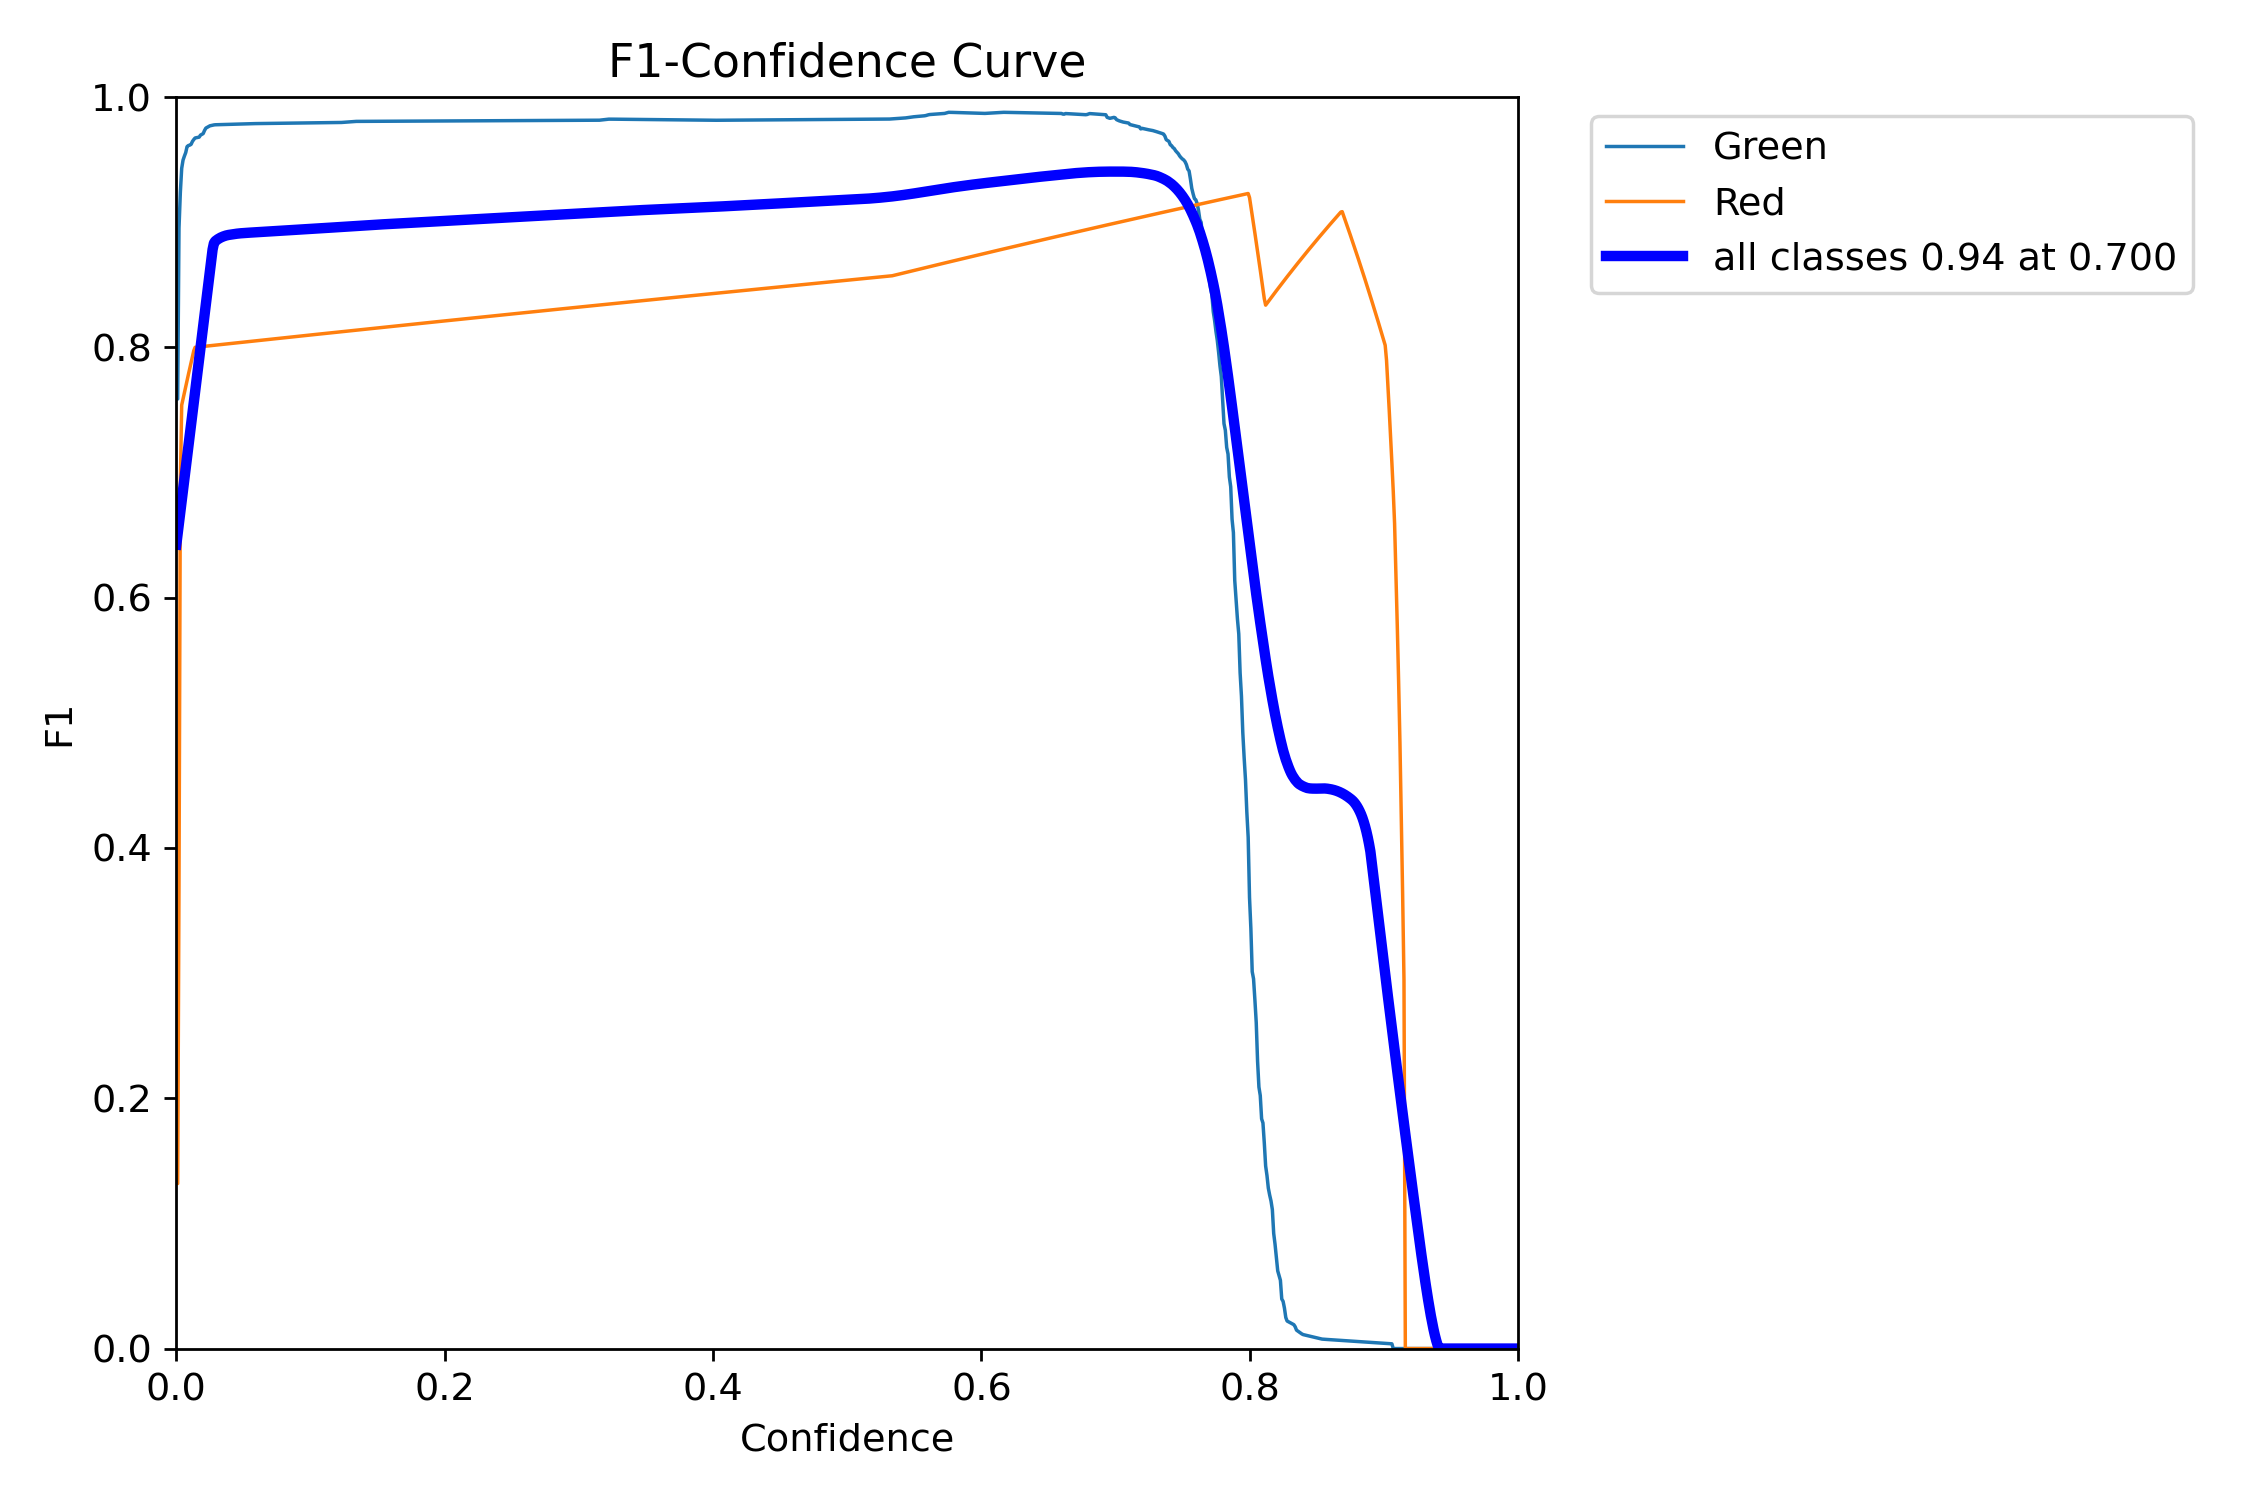

In [30]:
# F1 Curve Metrics Result 
IPyImage(filename='/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/train23/F1_curve.png', width=600)

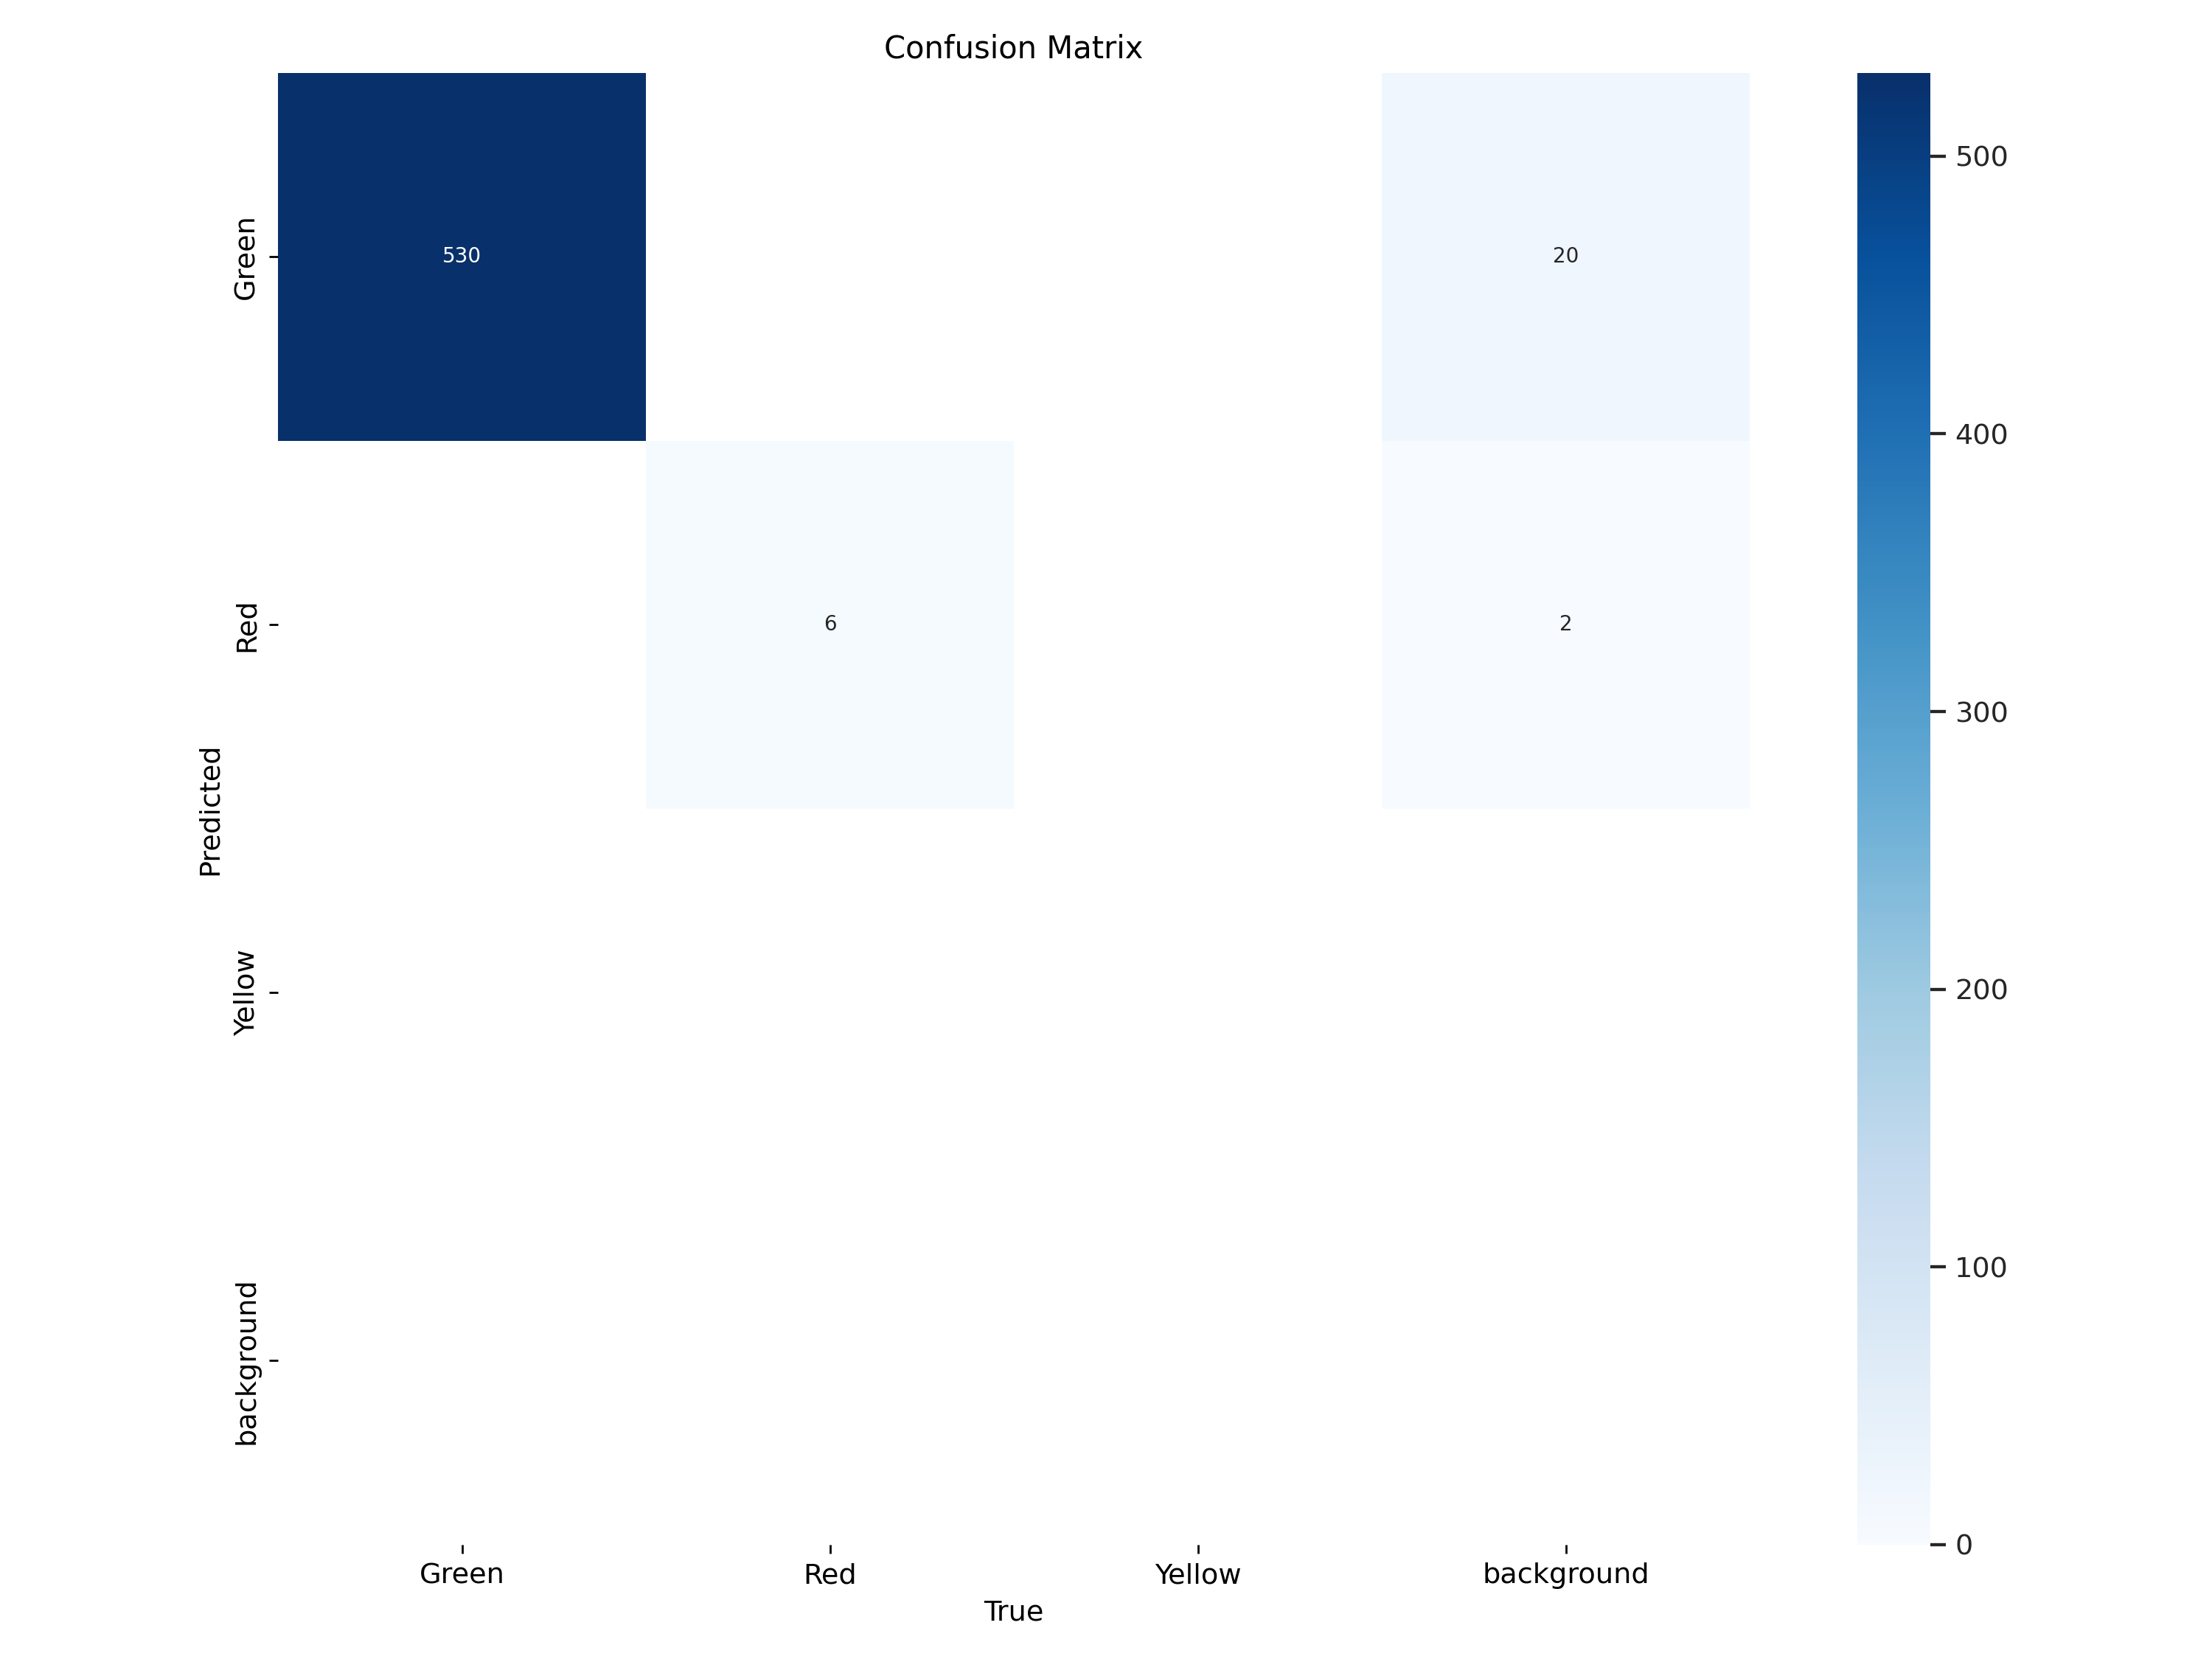

In [31]:
# Confussion Matrix
IPyImage(filename='/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/train23/confusion_matrix.png', width=600)

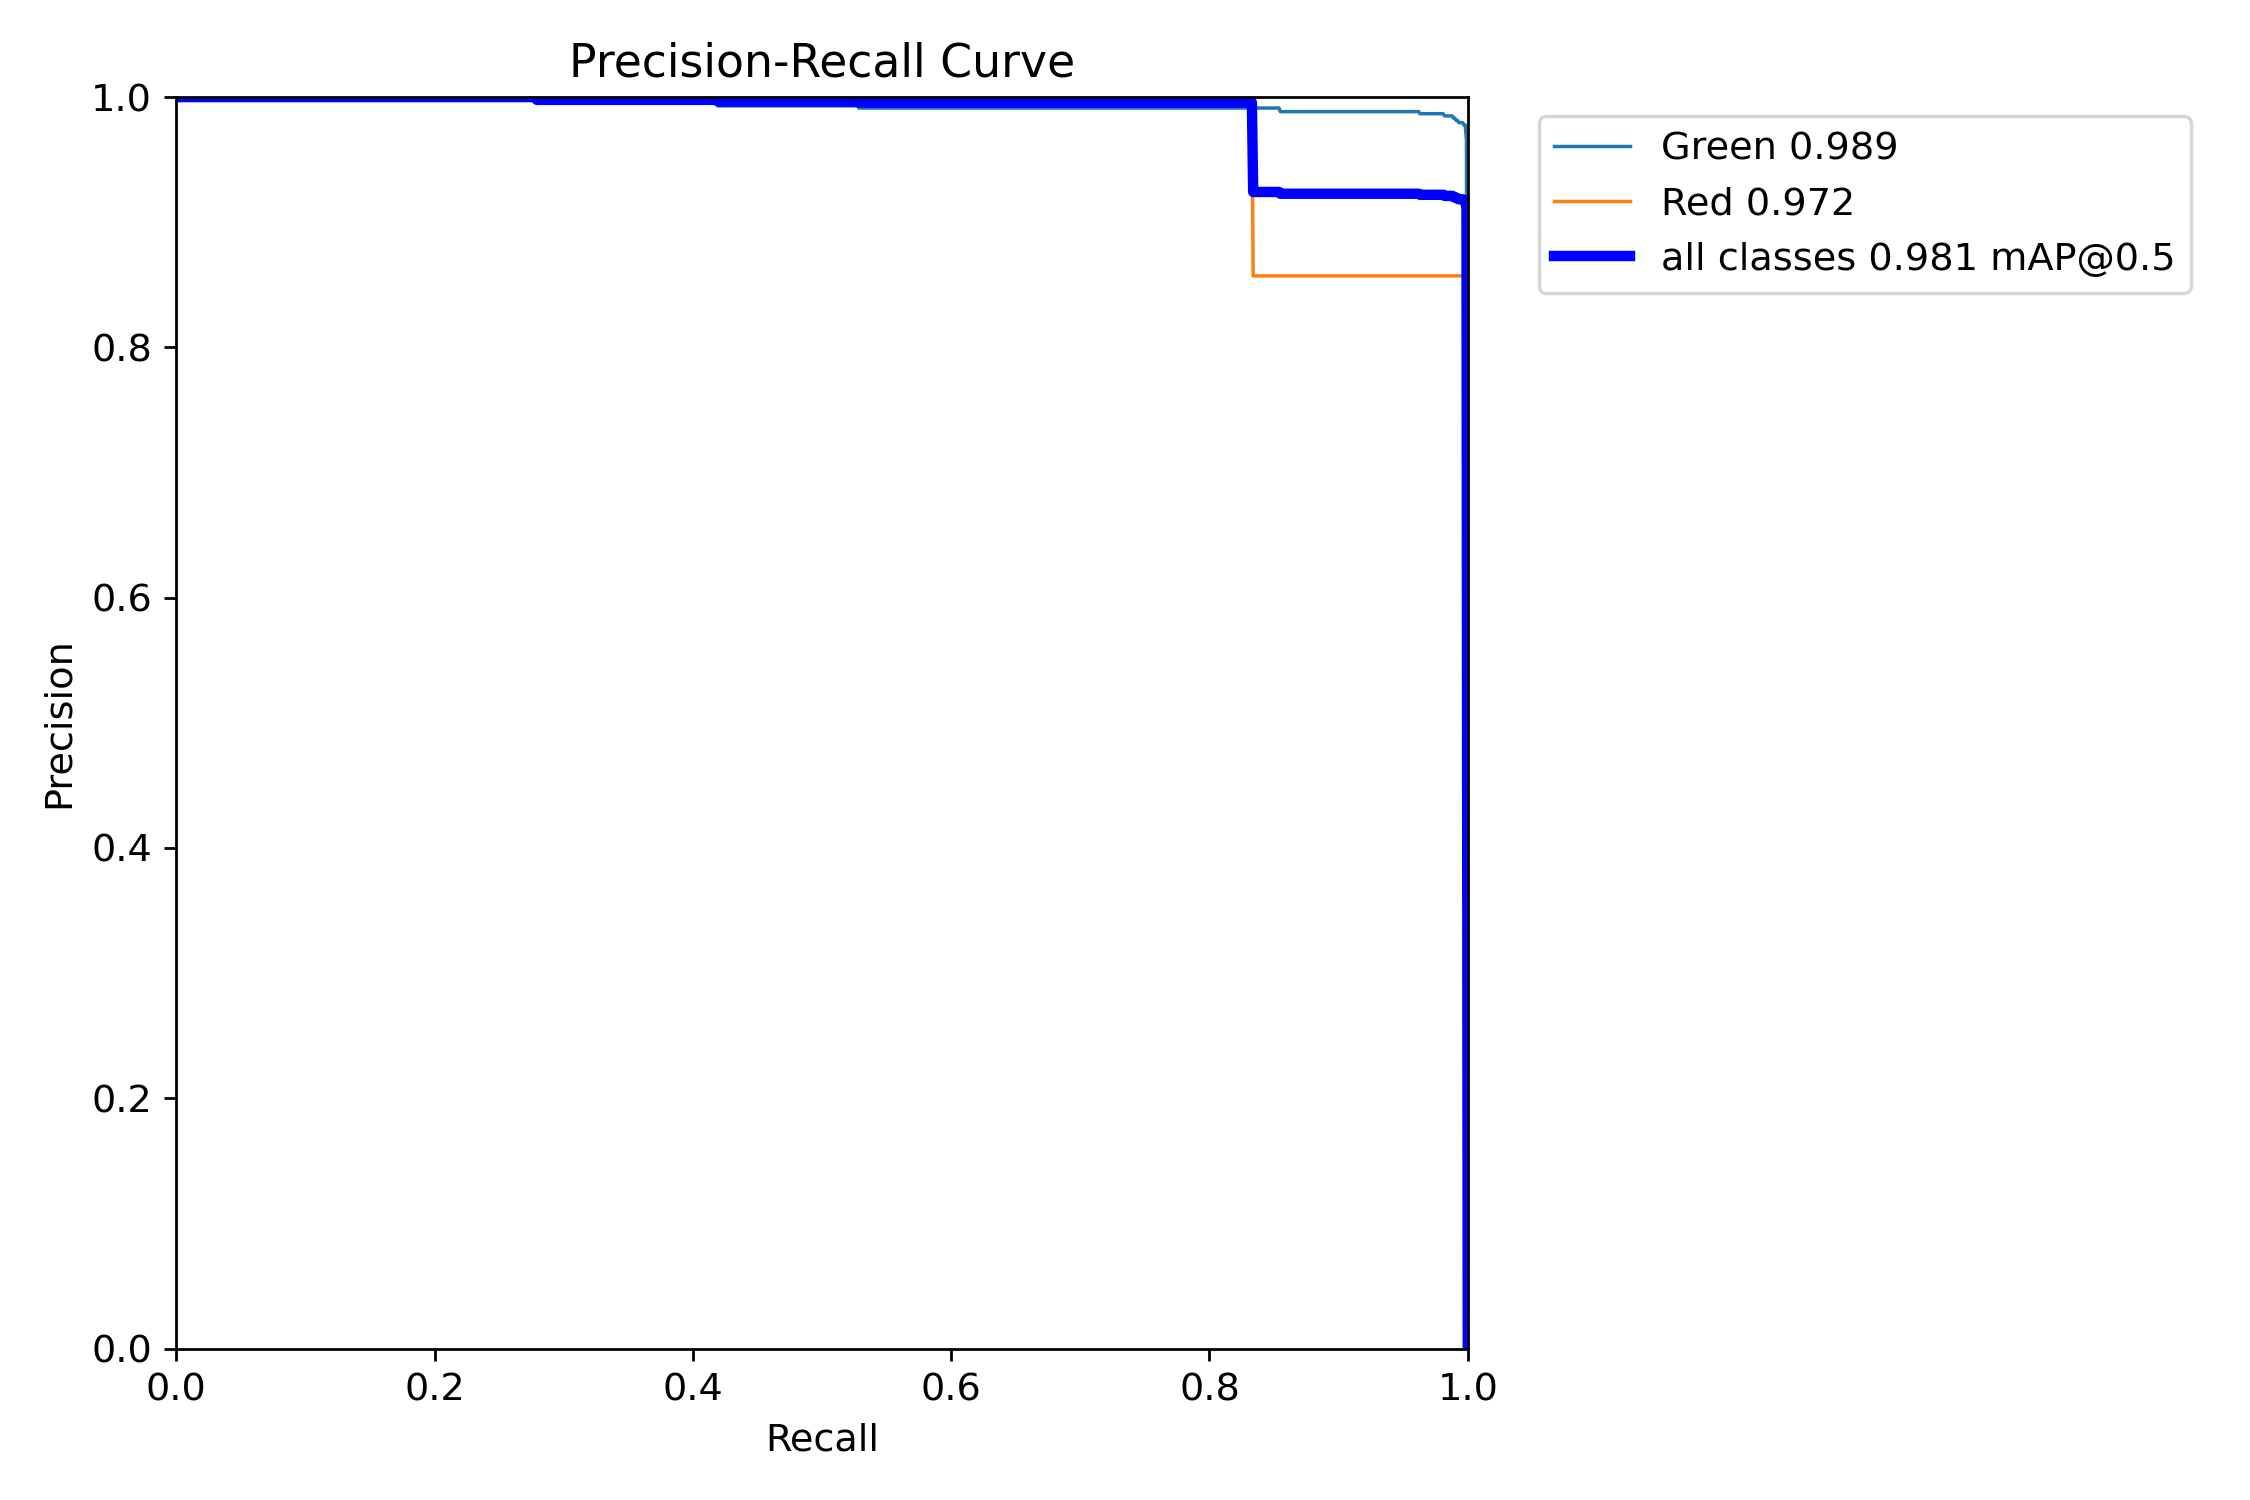

In [32]:
# Precision-Recall Curve Metrics Result
IPyImage(filename='/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/train23/PR_curve.png', width=600)


image 1/1 /workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/clasify-target.jpeg: 1024x1280 1 Green, 3 Reds, 10 Yellows, 14.8ms
Speed: 10.6ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1280)


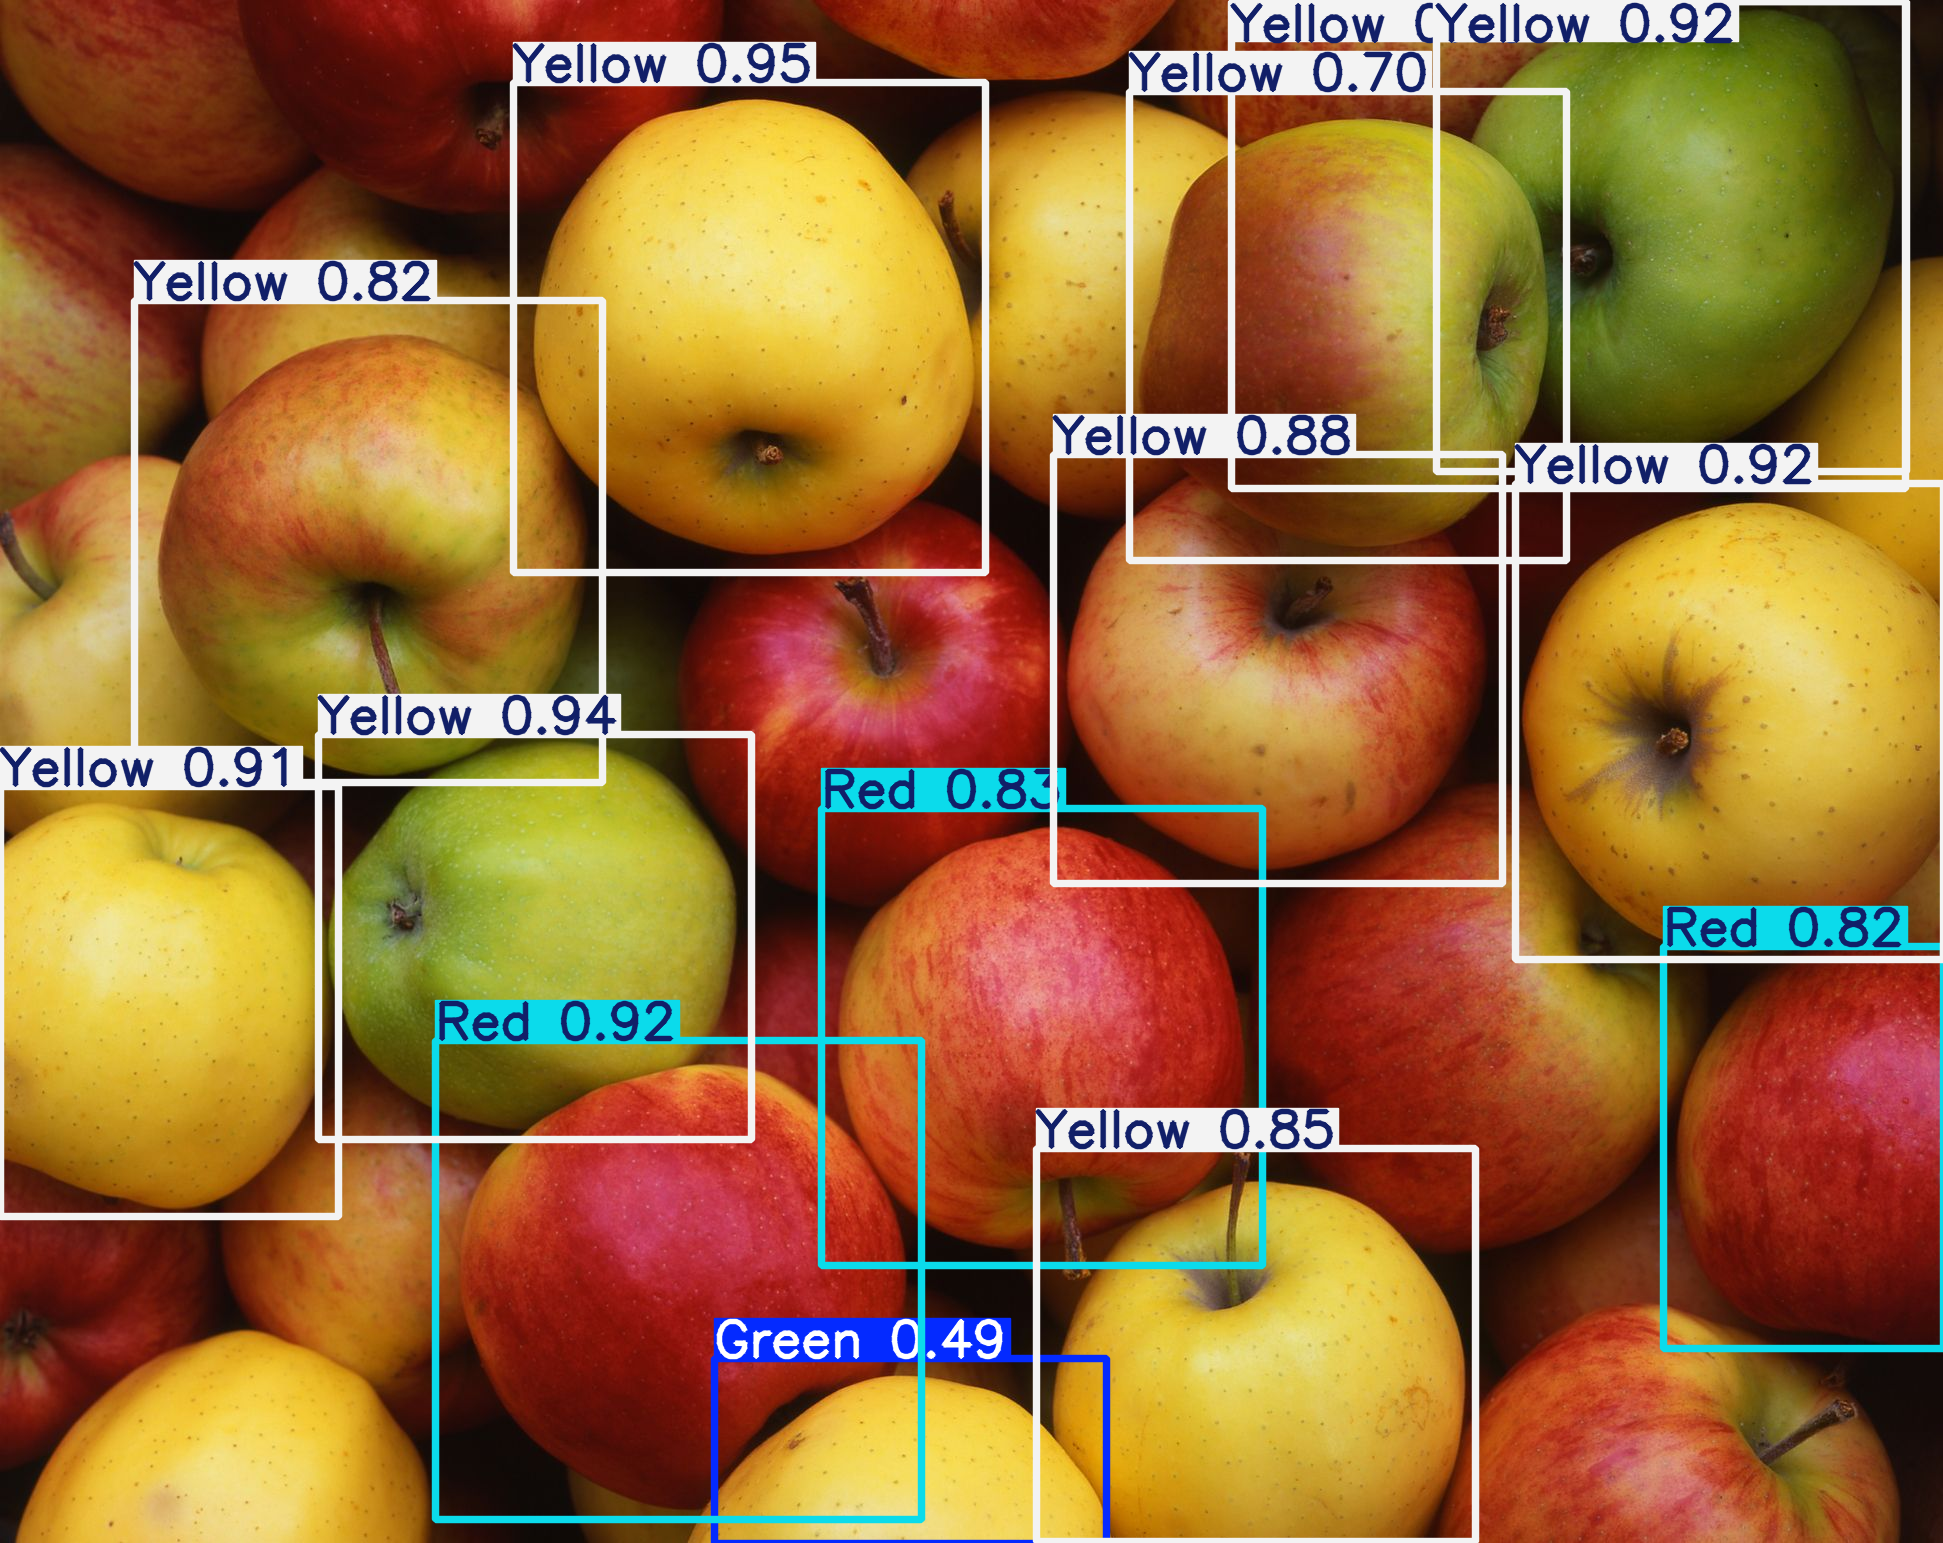

In [42]:
# Run inference on task image

tuned_model = YOLO("/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/runs/detect/train23/weights/best.pt")
# results = tuned_model('/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/clasify-target.jpeg')

tuned_model.overrides['imgsz'] = 1280 #overriding model input image for precision in cost of inference time
# tuned_model.overrides['verbose'] = False
results = tuned_model('/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/clasify-target.jpeg', conf=0.4, iou=0.7)

# Process results list
for result in results:
    result.save_crop(save_dir="/workspace/Aerial-Palm-Tree-Object-Detection/notebooks/experiments/cropped", file_name="detection") #save cropped detected class
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk